In [1]:
import pickle
import os
import re
import glob
import pandas as pd

In [2]:
os.chdir('C:\RotorCraftData\DAEN690-Karate_Choppers')
print(os.getcwd())

C:\RotorCraftData\DAEN690-Karate_Choppers


In [3]:
import pickle
import os
import re
import pandas as pd

# this is the path to the folder where you have the CSVs, NO OTHER CSVs SHOULD BE PRESENT
# please make sure this path is not inside the scope of GitHub so we do not go over on data for our repo
path = r'C:\RotorCraftData\CSV1\CSV'
pattern = r'.*2023\.06\.15.*\.csv$'

use_cols_dr = ['Elapsed Time', 'Date', 'System UTC Time', 'Altitude(MSL)', 'Altitude(AGL)', 'Roll Acceleration', 'Pitch Acceleration', 'Yaw Acceleration', 
               'Roll', 'Pitch', 'Yaw', 'Roll Rate', 'Pitch Rate', 'Yaw Rate', 'Groundspeed', 'Wind Speed(True)', 'Sideslip Angle', 'Gross Weight', 'Cyclic Pitch Pos-[0]', 
               'Cyclic Roll Pos-[0]', 'Collective Pos-[0]', 'Pedal Pos', 'Rotor Torque-[0]']

use_cols_lg = ['Elapsed Time', 'Date', 'System UTC Time', 'Altitude(MSL)', 'Altitude(AGL)', 'Airspeed(True)', 'Roll Acceleration', 
               'Pitch Acceleration', 'Yaw Acceleration', 'Roll', 'Pitch', 'Yaw', 'Rotor RPM-[0]', 'Sideslip Angle', 'Vert. Speed', 'Gross Weight','Cyclic Pitch Pos-[0]', 
               'Cyclic Roll Pos-[0]', 'Collective Pos-[0]', 'Pedal Pos', 'Rotor Torque-[0]', 'Wind Speed(True)']

# the data will be labeled using the information from the flight logs
label_table = pd.DataFrame({
    'Date': ['2023-06-15', '2023-06-15', '2023-06-15', '2023-06-15', '2023-06-15', '2023-06-15', '2023-06-15', '2023-06-15', '2023-06-15', '2023-06-15', '2023-06-15', '2023-06-15', '2023-06-15', '2023-06-15', '2023-06-15', '2023-06-15', '2023-06-15', '2023-06-15'],  # Replace with actual dates of maneuvers
    # Replace with actual start time of maneuvers
    'StartTime': ['13:22:15.0', '13:25:25.0', '13:29:25.0', '11:56:25.0', '11:58:03.0', '11:59:51.0', '16:10:04.0', '16:11:41.0', '16:14:20.0', '13:43:12.0', '13:44:10.0', '13:45:19.0', '12:08:11.0', '12:09:31.0', '12:10:51.0', '16:34:28.0', '16:35:06.0', '16:38:26.0'],
    # Replace with actual end time of maneuvers
    'EndTime': ['13:22:25.0', '13:25:38.0', '13:29:40.0', '11:56:38.0', '11:58:24.0', '12:00:00.0', '16:10:12.0', '16:11:46.0', '16:14:29.0', '13:43:35.0', '13:44:18.0', '13:45:30.0', '12:08:35.0', '12:09:52.0', '12:11:18.0', '16:34:42.0', '16:35:27.0', '16:38:36.0'],
    'Label': ['Dynamic Rollover', 'Dynamic Rollover', 'Dynamic Rollover', 'Dynamic Rollover', 'Dynamic Rollover', 'Dynamic Rollover', 'Dynamic Rollover', 'Dynamic Rollover', 'Dynamic Rollover', 'LOW-G', 'LOW-G', 'LOW-G', 'LOW-G', 'LOW-G', 'LOW-G', 'LOW-G', 'LOW-G', 'LOW-G']  # Replace with maneuver names
})

# convert date, start time, and end time columns to datetime type
label_table['Date'] = pd.to_datetime(label_table['Date'])
label_table['StartTime'] = pd.to_datetime(
    label_table['StartTime'], format='%H:%M:%S.%f').dt.strftime('%H:%M:%S.%f')
label_table['EndTime'] = pd.to_datetime(
    label_table['EndTime'], format='%H:%M:%S.%f').dt.strftime('%H:%M:%S.%f')


def combine_csv_files(csv_directory, columns_to_use, label_df):
    # get list of CSV file paths in the directory
    csv_files = [os.path.join(csv_directory, filename) for filename in os.listdir(
        csv_directory) if re.match(pattern, filename)]
    # create an empty dataframe to store the combined data
    combined_df = pd.DataFrame()

    # iterate over each CSV file
    for file in csv_files:
        # read CSV file and select desired columns
        temp_df = pd.read_csv(file, usecols=columns_to_use, names=columns_to_use, skiprows=3, skipfooter=1, engine='python')
        # drop rows that Elapsed Time are mostly null, these are the breaks in simulation
        temp_df.dropna(subset=['Elapsed Time'], inplace=True)
        # temp_df.drop(['Elapsed Time'], inplace=True)
        temp_df.dropna(inplace=True)
        # concatenate the temporary dataframe with the running dataframe
        combined_df = pd.concat([combined_df, temp_df], ignore_index=True)

    # convert the time column on original df to correct format
    combined_df['System UTC Time'] = pd.to_datetime(
    combined_df['System UTC Time'], format='%H:%M:%S.%f').dt.strftime('%H:%M:%S.%f')
    # convert the date column on original df to correct format
    combined_df['Date'] = pd.to_datetime(combined_df['Date'])
    
    # apply the labeling to the dataset
    for _, row in label_df.iterrows():
        # extract date, start time, and end time from the current row
        date = row['Date']
        start_time = row['StartTime']
        end_time = row['EndTime']
        label = row['Label']

        # filter the existing dataset based on matching date and within start time and end time
        filter_condition = (combined_df['Date'] == date) & (
            combined_df['System UTC Time'].between(start_time, end_time))
        combined_df.loc[filter_condition, 'Label'] = label
    dummies_df = pd.get_dummies(combined_df['Label'], dummy_na=False)
    dummies_df = dummies_df.astype(int)
    combined_df = pd.concat([combined_df, dummies_df], axis=1)
    # Convert the time column to pandas datetime format if it's not already in that format
    combined_df['System UTC Time'] = pd.to_datetime(combined_df['System UTC Time'], format='%H:%M:%S.%f')

    # Set the start and end time range
    start_time = pd.to_datetime('11:56:25.0', format='%H:%M:%S.%f')
    end_time = pd.to_datetime('16:38:26.0', format='%H:%M:%S.%f')

    # Filter the DataFrame to include rows between the start and end times
    combined_df = combined_df[(combined_df['System UTC Time'] >= start_time) & (combined_df['System UTC Time'] <= end_time)].copy()

    combined_df.drop(['Elapsed Time', 'Date', 'System UTC Time', 'Label'], inplace=True, axis=1)
    
    return combined_df

# this calls the function from above that cleans and creates dummy variables for our target variables
df_dr = combine_csv_files(path, use_cols_dr, label_table)
df_dr.drop(['LOW-G'], inplace=True, axis=1)

df_lg = combine_csv_files(path, use_cols_lg, label_table)
df_lg.drop(['Dynamic Rollover'], inplace=True, axis=1)
# this will create a pickle file with the working dataframe in your directory with the original CSV files
# you will not need to run this script again, as we will load in the dataframe from the pickle file
with open(f'{path}/dynamic_rollover.pkl', 'wb') as f:
    pickle.dump(df_dr, f)

with open(f'{path}/low_g.pkl', 'wb') as f:
    pickle.dump(df_lg, f)

In [4]:
df_lg.shape

(258905, 20)

In [5]:
cols = df_lg.columns
cols

Index(['Altitude(MSL)', 'Altitude(AGL)', 'Airspeed(True)', 'Roll Acceleration',
       'Pitch Acceleration', 'Yaw Acceleration', 'Roll', 'Pitch', 'Yaw',
       'Rotor RPM-[0]', 'Sideslip Angle', 'Vert. Speed', 'Gross Weight',
       'Cyclic Pitch Pos-[0]', 'Cyclic Roll Pos-[0]', 'Collective Pos-[0]',
       'Pedal Pos', 'Rotor Torque-[0]', 'Wind Speed(True)', 'LOW-G'],
      dtype='object')

 # Decision tree
1.  Decision tree train/test split 
https://www.datacamp.com/tutorial/decision-tree-classification-python

In [6]:
# Load libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [7]:
df_lg.head()

,Altitude(MSL),Altitude(AGL),Airspeed(True),Roll Acceleration,Pitch Acceleration,Yaw Acceleration,Roll,Pitch,Yaw,Rotor RPM-[0],Sideslip Angle,Vert. Speed,Gross Weight,Cyclic Pitch Pos-[0],Cyclic Roll Pos-[0],Collective Pos-[0],Pedal Pos,Rotor Torque-[0],Wind Speed(True),LOW-G
0,39.464819,-74.565922,57.59,0.07,315.631,303.330,0.156,0.144,303.054,-0.010,0.006,0.0,-0.0,0.0,0.0,57.585,29.92,57.585,29.92,0
1,39.464819,-74.565922,57.59,0.07,315.631,303.330,0.156,0.144,303.054,-0.010,0.006,0.0,-0.0,0.0,0.0,57.585,29.92,57.585,29.92,0
2,39.464819,-74.565922,57.59,0.07,315.631,303.330,0.156,0.144,303.054,-0.010,0.006,0.0,-0.0,0.0,0.0,57.585,29.92,57.585,29.92,0
3,39.464819,-74.565922,57.59,0.07,315.631,303.330,0.156,0.144,303.054,-0.012,0.007,0.0,-0.0,0.0,0.0,57.585,29.92,57.585,29.92,0
4,39.464819,-74.565922,57.59,0.07,315.631,303.331,0.156,0.144,303.055,-0.016,0.008,0.0,-0.0,0.0,0.0,57.585,29.92,57.585,29.92,0


# Splitting the dataset into train and test for DT

In [9]:
#make a train/test split and scale the predictors with the StandardScaler class:
#X is the predictors, y and z has the response variables.
X = df_lg.drop(['LOW-G'], axis=1)
y =  df_lg['LOW-G']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [10]:


ss = StandardScaler()
#Scaling X 
X_scaled = ss.fit_transform(X)
#Scaling the train and test sets.
X_train_scaled = ss.fit_transform(X_train) # The dataset over which the model will be trained
y_train_scaled = ss.fit_transform(X_train) # This contains the dynamic rollover target
X_test_scaled = ss.transform(X_test)
y_test_scaled = ss.transform(X_test)



# #  Build and fit the model

In [11]:
# Create Decision Tree classifer object
DT_lowGmodel = DecisionTreeClassifier(random_state = 42) # LOW-G DT model

# Fit the model on training sets
DT_lowGmodel = DT_lowGmodel.fit(X_train, y_train) # lowG

# Make predictions

In [12]:
y_pred = DT_lowGmodel.predict(X_test) 
print("Predicted values:")
print(y_pred)
# Predict the probability of each class
y_predProba = DT_lowGmodel.predict_proba # lowG

Predicted values:
[0 0 0 ... 0 0 0]


In [16]:
# get importance
from matplotlib import pyplot
import numpy as np
#Get and sort feature of importance
importances = DT_lowGmodel.feature_importances_
lg_indices = np.argsort(importances)[::-1]
# Retrieve feature names from the training set
feature_names = list(X_train.columns)
# Print the most important variables
print("Most important variables:")
for i in lg_indices:
    print(f"{feature_names[i]}: {importances[i]}")


Most important variables:
Altitude(MSL): 0.3867358357833155
Roll Acceleration: 0.2801415369887027
Vert. Speed: 0.14299081022160678
Roll: 0.12105113455391568
Rotor RPM-[0]: 0.04605262135418529
Yaw: 0.023028061098274155
Cyclic Pitch Pos-[0]: 0.0
Gross Weight: 0.0
Cyclic Roll Pos-[0]: 0.0
Sideslip Angle: 0.0
Rotor Torque-[0]: 0.0
Pitch: 0.0
Collective Pos-[0]: 0.0
Yaw Acceleration: 0.0
Pitch Acceleration: 0.0
Pedal Pos: 0.0
Airspeed(True): 0.0
Altitude(AGL): 0.0
Wind Speed(True): 0.0


In [17]:
# Plot the feature importances of the forest
#plt.figure()
#plt.title("Decision Tree feature of importance for LOW-G")
#plt.barh(range(X.shape[1]),  [importances[i] for i in lg_indices],
 #      color="r", align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
#plt.yticks(range(X.shape[1]), [feature_names[i] for i in lg_indices])
#plt.ylim([-1, X.shape[1]])
#plt.show()

In [18]:
#Loading the feature importance into a panda series indexed by columns names and then use plot method.
#feat_importances = pd.Series(model.feature_importances_, index=X.columns)
#feat_importances.nlargest(20).plot(kind='barh')

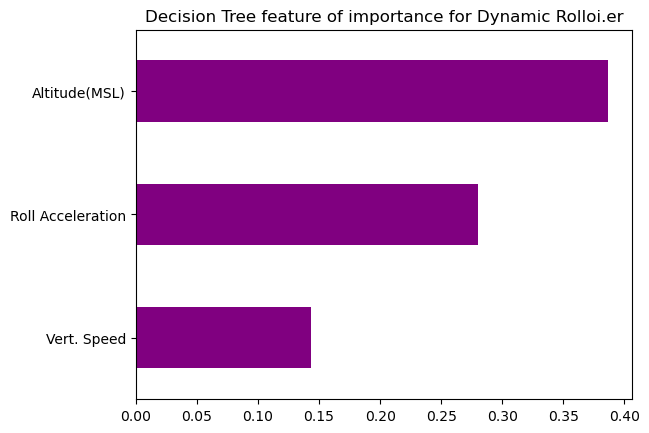

In [19]:
#Plotting the feature of importance
#nlargest(n) is a pandas Series method which will return a subset of the series with the largest n values. 
#This is useful if you've got lots of features in your model and you only want to plot the most important.
(pd.Series(DT_lowGmodel.feature_importances_, index=X_train.columns)
   .nlargest(3)
   .plot(kind='barh', color="purple", align="center", 
    title="Decision Tree feature of importance for Dynamic Rolloi.er").invert_yaxis())

# # Adding tuning parameters and fitting for Decision tree

In [20]:
#Using max_depth, criterion, max_features, min_samples_split
parameters = {'max_depth' : (10,30,50, 70, 90, 100),
             'criterion': ('gine', 'entropy'),
             'max_features' : ('auto', 'sqrt', 'log2'),
             'min_samples_split': (2,4,6, 8, 10)}

In [21]:
import warnings
warnings.filterwarnings('ignore')

In [22]:
#LOW-G grid
dt_LGgrid = RandomizedSearchCV(DecisionTreeClassifier(),param_distributions=parameters, cv = 5, verbose = True)
#fit the grid
dt_LGgrid.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(),
                   param_distributions={'criterion': ('gine', 'entropy'),
                                        'max_depth': (10, 30, 50, 70, 90, 100),
                                        'max_features': ('auto', 'sqrt',
                                                         'log2'),
                                        'min_samples_split': (2, 4, 6, 8, 10)},
                   verbose=True)

# # Finding best estimators

In [23]:
#Find the best estimator For lowG
lgbest_estimator = dt_LGgrid.best_estimator_

# # Rebuilding the models based on the best estimator results.

In [24]:
#Re build the model with best estimators for lowG
DT_lowGmodel = DecisionTreeClassifier(criterion='entropy', max_depth=30, max_features='sqrt', 
                                    min_samples_split=6)

lowG_model = DT_lowGmodel.fit(X_train, y_train)

In [25]:
# imports for classifiers and metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
#I'm replacing X_train with X only since I am testing X,Y fitted
#Print accuracy of the lowG model
print(f'Train Accuracy - : {DT_lowGmodel.score(X_train, y_train): .3f}')
print(f'Train Accuracy - : {DT_lowGmodel.score(X_test, y_test): .3f}')


Train Accuracy - :  1.000
Train Accuracy - :  1.000


# # Evaluating the Model

In [26]:
# imports for classifiers and metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
#Scores without using average setting for f1 score
score_lowG_Macro = f1_score(y_pred, y_test)
print('Simple F1 score for LOW-G:',  score_lowG_Macro)
# F1 score
# FORMULA- F1 = 2 * (precision * recall) / (precision + recall)
#'macro':Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
score_lowG_Macro = f1_score(y_pred, y_test, average='macro')
print('LOW-G f1 Macro score:',score_lowG_Macro)
#'micro':Calculate metrics globally by counting the total true positives, false negatives and false positives.
score_lowG_Micro = f1_score(y_pred, y_test, average='micro')
print('LOW-G f1 Micro score:',score_lowG_Micro)
# 'weighted':Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.
score_lowG_W = f1_score(y_pred, y_test, average='weighted')
print('LOW-G f1 Weighted score:', score_lowG_W)


Simple F1 score for LOW-G: 0.9975845410628019
LOW-G f1 Macro score: 0.9987844960534571
LOW-G f1 Micro score: 0.9999691009934031
LOW-G f1 Weighted score: 0.9999691009934031


# Confusion matrix and Classification report for LOW-G

In [27]:
from sklearn.model_selection import KFold, cross_val_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report




In [28]:
#LOW-G 
cm_lowG = confusion_matrix(y_pred, y_test)
print(cm_lowG)

#LOW-G Classification report
print("Classification report for LOW-G: \n",
      classification_report(y_test, y_pred))

[[64312     1]
 [    1   413]]
Classification report for LOW-G: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     64313
           1       1.00      1.00      1.00       414

    accuracy                           1.00     64727
   macro avg       1.00      1.00      1.00     64727
weighted avg       1.00      1.00      1.00     64727



In [29]:
from sklearn.model_selection import KFold, cross_val_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

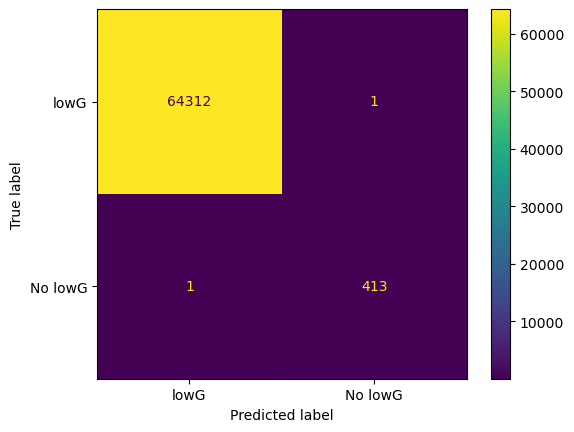

In [30]:
#Top left = TrueNegative, Topright= FalseNegative , bottonleft=FalsePositive , bottonright= True positive 
cm = ConfusionMatrixDisplay(confusion_matrix=cm_lowG, display_labels=['lowG','No lowG'])
cm.plot()

# # Visualizing Decision Trees

In [31]:
import sklearn
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, to_rgb
from sklearn.tree import export_graphviz
import graphviz
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [32]:
# Retrieve feature names
feature_names = list(X_train.columns)
print(feature_names)

['Altitude(MSL)', 'Altitude(AGL)', 'Airspeed(True)', 'Roll Acceleration', 'Pitch Acceleration', 'Yaw Acceleration', 'Roll', 'Pitch', 'Yaw', 'Rotor RPM-[0]', 'Sideslip Angle', 'Vert. Speed', 'Gross Weight', 'Cyclic Pitch Pos-[0]', 'Cyclic Roll Pos-[0]', 'Collective Pos-[0]', 'Pedal Pos', 'Rotor Torque-[0]', 'Wind Speed(True)']


In [33]:
#Create a class to store the dependent variable names for labeling the decision tree
# I created it two classes
class_namesdr = '0','1' # lowG


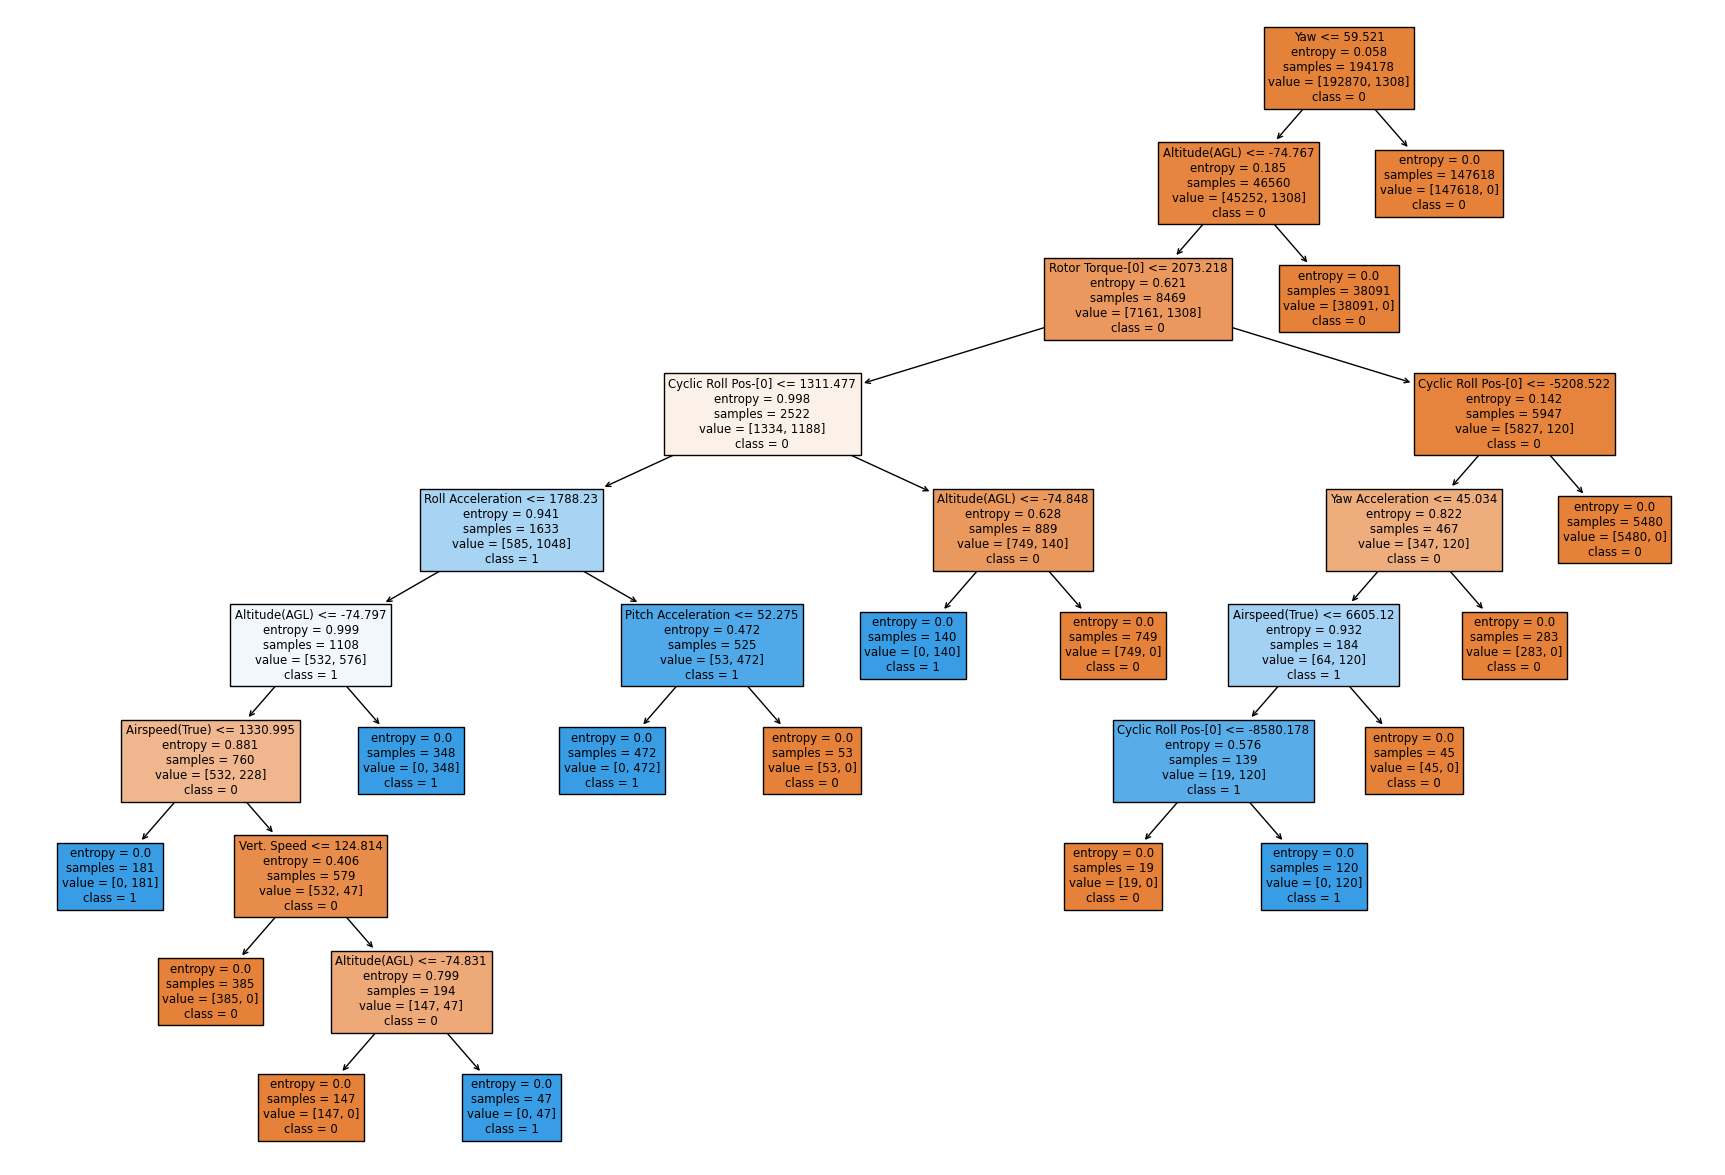

In [34]:
# plot decision tree for LOW-G
plt.figure(figsize=(22, 15))
plot_tree(DT_lowGmodel, 
        feature_names= feature_names,
        class_names=class_namesdr , filled=True)
plt.show()

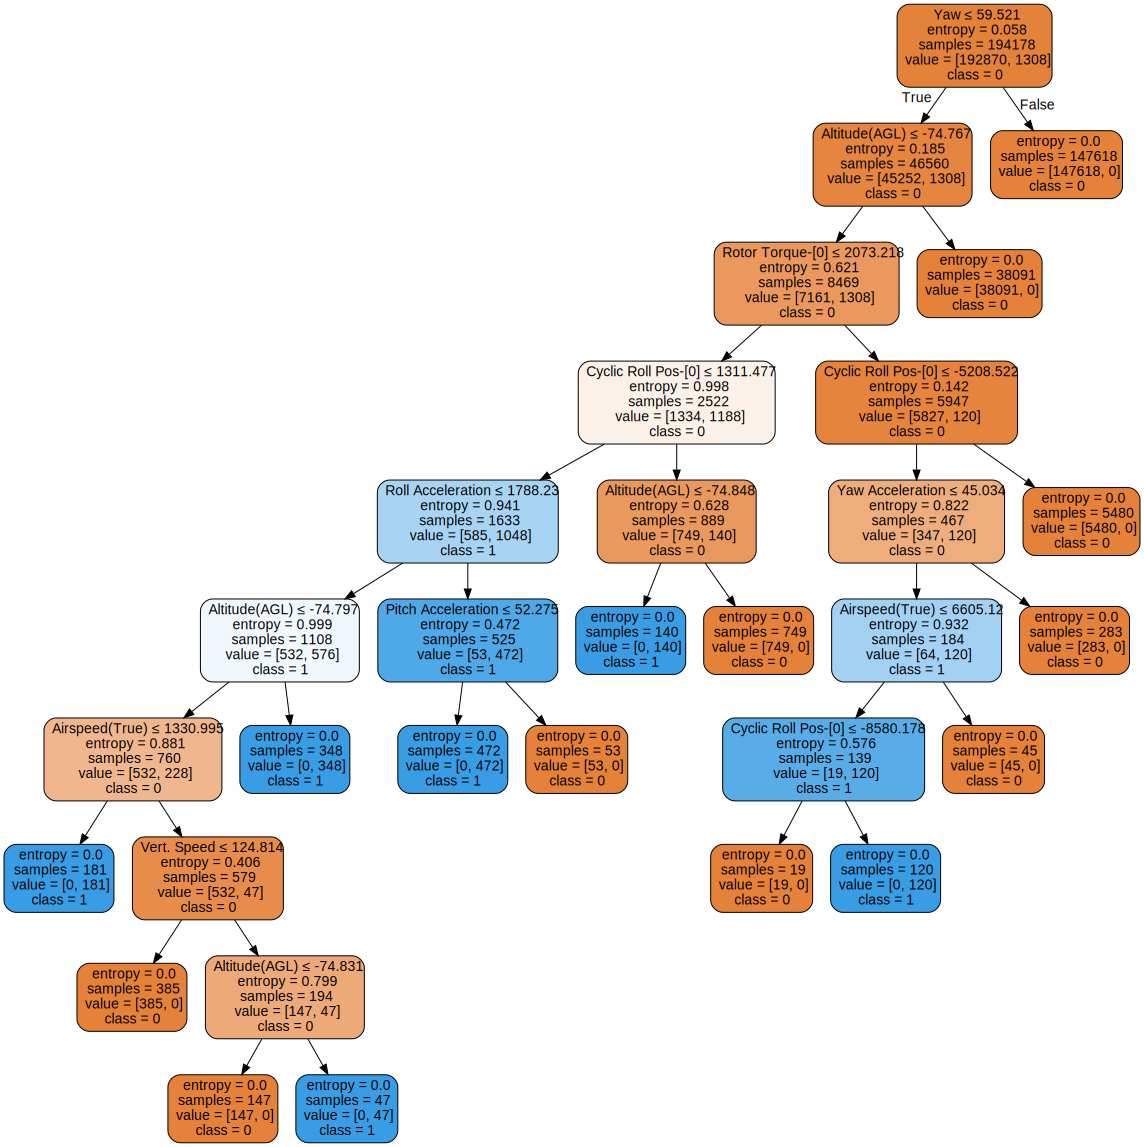

In [35]:
# Visualization of LOW-G
dot_data = tree.export_graphviz(DT_lowGmodel, feature_names= feature_names, class_names=class_namesdr , filled=True) 
lowGgraph = graphviz.Source(dot_data, format='png') 
lowGgraph.render("lowGGraph") 
dot_data = tree.export_graphviz (DT_lowGmodel, feature_names= feature_names, class_names=class_namesdr , filled=True,
        rounded = True,
        special_characters=True)
lowGgraph=graphviz.Source(dot_data) 
lowGgraph

# ROC curve

In [36]:
#ROC is a plot between Fpositive and true positive rate(tpr).
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, auc

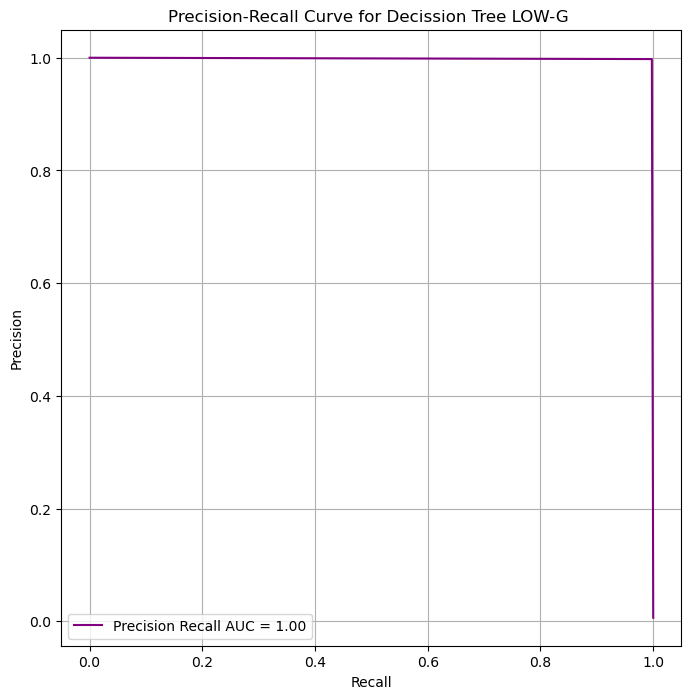

In [37]:
# calculation of precision-recall curve for DT LOW-G
precision, recall, _ = precision_recall_curve(y_test, y_pred)

# The precision-recall curve for lowG
pr_auc = auc(recall, precision)

# plot precision-recall curve
plt.figure(figsize=(8, 8))
plt.plot(recall, precision, color='purple', label=f'Precision Recall AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Decission Tree LOW-G ')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()



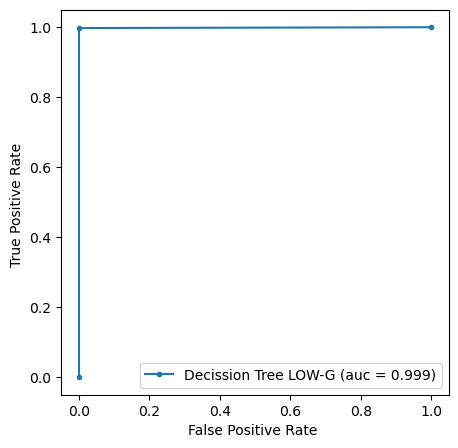

In [38]:
#ROC for LOW_G
decisiontree_fpr, decissiontree_tpr, threshold = roc_curve(y_test, y_pred)
auc_decisiontree = auc(decisiontree_fpr,decissiontree_tpr)
plt.figure(figsize=(5,5), dpi=100)
plt.plot(decisiontree_fpr,decissiontree_tpr, marker='.', label='Decission Tree LOW-G (auc = %0.3f)'% auc_decisiontree)
plt.xlabel('False Positive Rate ')
plt.ylabel('True Positive Rate ')
plt.legend()

plt.show()